In [9]:
import scanpy as sc
import numpy as np
import scipy.sparse as sp

In [4]:
adata = sc.read_h5ad("03a-aml-BM-integrated-complete.h5ad")
print("obsm keys:", list(adata.obsm.keys()))
adata
# 期望看到 "X_pca" 和 "X_harmony"

obsm keys: ['X_harmony', 'X_pca']


AnnData object with n_obs × n_vars = 49641 × 2000
    obs: 'prject', 'nUMI', 'nGene', 'cellID', 'Doublet_Score', 'Doublet_Class', 'log10GenesPerUMI', 'mitoRatio', 'riboRatio1', 'riboRatio2', 'riboRatio3', 'riboRatio4', 'riboRatio', 'RNA_snn_res.0', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'class1', 'sample', 'source', 'S.Score', 'G2M.Score', 'Phase'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca'
    varm: 'HARMONY', 'PCs'

In [10]:
print(adata.raw is not None)
if adata.raw is not None:
    print(adata.raw.shape)   # 期望 ~ (49641, 27390)

old = adata  # 备份
assert old.raw is not None

# 1) 用 raw 构建一个“全基因”的新对象
adata_full = old.raw.to_adata()   # 形状会是 (49641, 27390)

# 2) 把 obs/obsm/uns 等元信息带回来（这些与基因数无关）
adata_full.obs = old.obs.copy()
adata_full.obsm = old.obsm.copy()    # 保留 X_harmony / X_pca
adata_full.uns = old.uns.copy()

# （可选）3) 把原 2k HVG 的 log1p 主矩阵保存为一个对齐到全基因的 layer，方便日后对照
hvg_genes = old.var_names
inter, idx_full, idx_hvg = np.intersect1d(adata_full.var_names, hvg_genes, return_indices=True)

# 建一个全 0 的稀疏层，然后把 2k HVG 的矩阵放到对应列
if sp.issparse(old.X):
    layer = sp.csr_matrix((adata_full.n_obs, adata_full.n_vars), dtype=old.X.dtype)
    layer[:, idx_full] = old.X[:, idx_hvg]
else:
    layer = np.zeros((adata_full.n_obs, adata_full.n_vars), dtype=old.X.dtype)
    layer[:, idx_full] = old.X[:, idx_hvg]

adata_full.layers["hvg_log1p"] = layer

# 4) 用新的全基因对象替换
adata = adata_full

# 检查
adata  # 现在应为 (49641, 27390)
list(adata.layers.keys())  # 包含 'hvg_log1p'（可选）
list(adata.obsm.keys())    # 仍有 'X_harmony'、'X_pca'



True
(49641, 27390)


['X_harmony', 'X_pca']

In [11]:
adata 

AnnData object with n_obs × n_vars = 49641 × 27390
    obs: 'prject', 'nUMI', 'nGene', 'cellID', 'Doublet_Score', 'Doublet_Class', 'log10GenesPerUMI', 'mitoRatio', 'riboRatio1', 'riboRatio2', 'riboRatio3', 'riboRatio4', 'riboRatio', 'RNA_snn_res.0', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'class1', 'sample', 'source', 'S.Score', 'G2M.Score', 'Phase'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca'
    layers: 'hvg_log1p'

In [31]:
import numpy as np
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

def compute_snn(adata, use_rep="X_harmony", k=20):
    X = adata.obsm[use_rep]
    nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(X)
    knn_graph = nbrs.kneighbors(X, return_distance=False)

    n_cells = X.shape[0]
    rows, cols, data = [], [], []

    for i in range(n_cells):
        neigh_i = set(knn_graph[i])
        for j in neigh_i:
            neigh_j = set(knn_graph[j])
            shared = len(neigh_i & neigh_j)
            if shared > 0:
                rows.append(i)
                cols.append(j)
                data.append(shared / (k - 1))  # Seurat 用 Jaccard-like
    snn_matrix = csr_matrix((data, (rows, cols)), shape=(n_cells, n_cells))
    return snn_matrix

# 构建 SNN 并存入 AnnData
adata.obsp["connectivities"] = compute_snn(adata, use_rep="X_harmony", k=20)

# Leiden 聚类
sc.tl.leiden(adata, resolution=1.6, key_added="leiden_1.6_snn")


In [ ]:


# 用 Harmony 空间构图与聚类（对应 Seurat: FindNeighbors/FindClusters）
sc.pp.neighbors(
    adata,
    use_rep="X_harmony",   # 等价于 Seurat reduction="harmony"
    n_neighbors=20,        # 对齐 Seurat 的 k.param
    method="gauss"         # Scanpy 没有完全等价的 SNN，这里只能尽量靠近
)

# for res in np.arange(1.0, 1.7, 0.1):
res = 1.6
sc.tl.leiden(adata, resolution=float(f"{res:.1f}"), key_added=f"leiden_{res:.1f}", random_state=123)



In [33]:
adata.obs["leiden_1.6_snn"].value_counts()

leiden_1.6_snn
0     5619
1     5136
2     3600
3     3480
4     3003
5     2871
6     2277
7     2223
8     1973
9     1786
10    1684
11    1507
12    1407
13    1140
14    1109
15    1097
16     966
17     913
18     898
19     880
20     804
21     717
22     675
23     669
24     627
25     347
26     312
27     297
28     257
29     251
30     248
31     171
32     169
33     156
34     125
35      69
36      60
37      51
38      32
39      20
40      15
Name: count, dtype: int64

In [14]:
adata

AnnData object with n_obs × n_vars = 49641 × 27390
    obs: 'prject', 'nUMI', 'nGene', 'cellID', 'Doublet_Score', 'Doublet_Class', 'log10GenesPerUMI', 'mitoRatio', 'riboRatio1', 'riboRatio2', 'riboRatio3', 'riboRatio4', 'riboRatio', 'RNA_snn_res.0', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'class1', 'sample', 'source', 'S.Score', 'G2M.Score', 'Phase', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6'
    obsm: 'X_harmony', 'X_pca'
    layers: 'hvg_log1p'
    obsp: 'distances', 'connectivities'

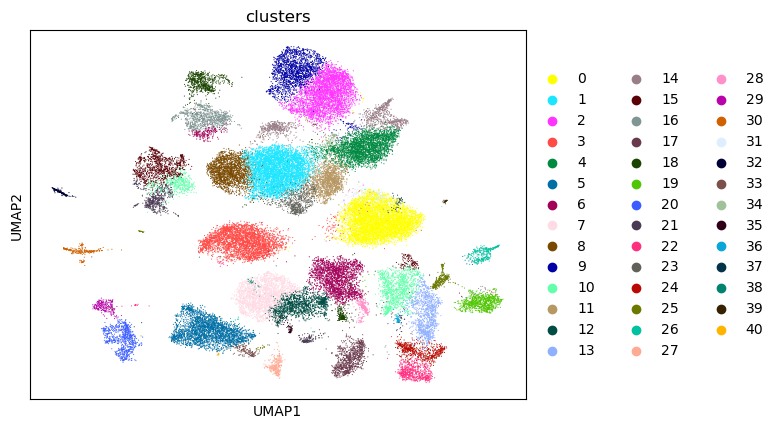

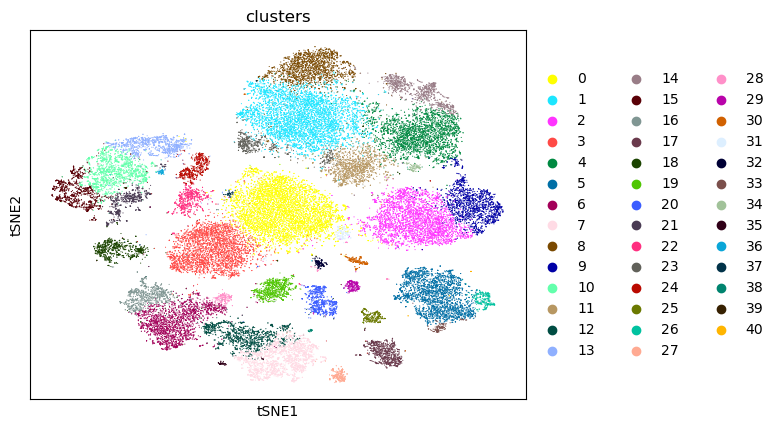

In [36]:

# 非线性降维（对应 Seurat: RunUMAP/RunTSNE）
sc.tl.umap(adata, random_state=123)                 # 默认用 neighbors 的同一空间
sc.tl.tsne(adata, use_rep="X_harmony", random_state=123)

# 选择与你在 R 里对应的分辨率作为当前簇列
adata.obs["clusters"] = adata.obs["leiden_1.6_snn"]

# 可视化检查
sc.pl.umap(adata, color=["clusters"])
sc.pl.tsne(adata, color=["clusters"])

# 保存结果
adata.write("03a-aml-BM-integrated-complete.scanpy.h5ad", compression="gzip")